In [1]:
import sys
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from datetime import datetime
sys.path.append("../")
from src.helpers import io
from src.classes.dataset import Dataset
from src.classes.annotation_set import AnnotationSet
from src.helpers.visualisation import (
    barplot_distribution,
    plot_confusion_matrix,
    tabulate_annotation_pair_summary,
    analyze_pair_annotations
)
%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/fatemehmireshghallah/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Research Questions:
# 1. What is the distribution of sensitive use flags?
# 2. What is the share of conversations flagged for sensitive uses compared to total labeled conversations?
# 3. What is the prevalence of sensitive, sexual, or illegal content in user queries?


In [2]:
# FILL IN:
PATH_TO_DATASET = "../data/static/wildchat4k-raw.json"
DATASET_ID = "wildchat_1m"
PATH_TO_ANNOTATIONS_DIR = "../res/gpto3mini-json-wildchat"

# Load dataset (w/o annotations)
dataset = Dataset.load(PATH_TO_DATASET)

# Load annotations into dataset
for fpath in io.listdir_nohidden(PATH_TO_ANNOTATIONS_DIR):
    annotation_set = AnnotationSet.load_automatic(path=fpath, source="automatic_v0")
    dataset.add_annotations(annotation_set)

prompt-multi_turn_relationship: 0 / 10127 failed due to invalid annotations.
prompt-interaction_features: 0 / 10127 failed due to invalid annotations.
turn-sensitive_use_flags: 0 / 10127 failed due to invalid annotations.
turn-topic: 1 / 10127 failed due to invalid annotations.
response-interaction_features: 0 / 10127 failed due to invalid annotations.
prompt-function_purpose: 6 / 10127 failed due to invalid annotations.
prompt-media_format: 0 / 10127 failed due to invalid annotations.
response-media_format: 0 / 10127 failed due to invalid annotations.
response-answer_form: 0 / 10127 failed due to invalid annotations.


# Research Question 1: What is the distribution of sensitive use flags?

# 

In [ ]:
# Create output directory
outdir = "data/annotation_analysis_v0/sensitive_use_flags"
os.makedirs(outdir, exist_ok=True)

level = "message"
# Get distribution of sensitive use flags
sensitive_flags_distribution = dataset.get_annotation_distribution(
    "turn_sensitive_use_flags",
    level=level,
    annotation_source="automatic_v0",
    annotation_as_list_type=False,
)

# Plot distribution
fig = barplot_distribution(
    {"Sensitive Use Flags": sensitive_flags_distribution}, 
    normalize=True, 
    xlabel="Flag Type", 
    ylabel="Proportion", 
    title=f"Distribution of Sensitive Use Flags at {level} Level",
    output_path=f"{outdir}/dist_flags_barchart_{level}.png", 
    order="descending"
)


# Display the raw counts and percentages
print(f"Distribution of sensitive use flags at {level} Level")
total_flags = sum(sensitive_flags_distribution.values())
for flag, count in sorted(sensitive_flags_distribution.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total_flags) * 100
    print(f"{flag}: {count} instances ({percentage:.2f}%)")



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Distribution of sensitive use flags at conversation Level


## Research Question 2: What is the share of conversations with sensitive flags?


In [29]:
# Count conversations with at least one sensitive flag
sensitive_conv_count = 0
total_conv_count = len(dataset.data)
conv_with_sensitive_flags = {}

for conv in dataset.data:
    has_sensitive_flag = False
    for msg in conv.conversation:
        if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
            flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
            
            # Handle both list and string cases
            if isinstance(flag_value, list):
                if any(flag != "None" for flag in flag_value):
                    has_sensitive_flag = True
                    break
            elif flag_value and flag_value != "None":
                has_sensitive_flag = True
                break
    
    if has_sensitive_flag:
        sensitive_conv_count += 1
        conv_with_sensitive_flags[conv.conversation_id] = True

# Calculate percentage
percentage_sensitive = (sensitive_conv_count / total_conv_count) * 100

print(f"Total conversations: {total_conv_count}")
print(f"Conversations with sensitive flags: {sensitive_conv_count}")
print(f"Percentage of conversations with sensitive flags: {percentage_sensitive:.2f}%")

# Create pie chart
plt.figure(figsize=(10, 6))
plt.pie([sensitive_conv_count, total_conv_count - sensitive_conv_count], 
        labels=['Sensitive', 'Non-sensitive'],
        autopct='%1.1f%%',
        startangle=90)
plt.axis('equal')
plt.title('Proportion of Conversations with Sensitive Content')
plt.savefig(f"{outdir}/pie_chart.png")
plt.close()

Total conversations: 4000
Conversations with sensitive flags: 593
Percentage of conversations with sensitive flags: 14.82%


## Research Question 3: Prevalence of sensitive content in user vs. assistant messages

In [30]:
# Count sensitive content by role (user vs. assistant)
user_sensitive_count = 0
assistant_sensitive_count = 0
total_user_msgs = 0
total_assistant_msgs = 0

for conv in dataset.data:
    for msg in conv.conversation:
        if msg.role == "user":
            total_user_msgs += 1
            if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                if isinstance(flag_value, list):
                    if any(flag != "None" for flag in flag_value):
                        user_sensitive_count += 1
                elif flag_value and flag_value != "None":
                    user_sensitive_count += 1
        elif msg.role == "assistant":
            total_assistant_msgs += 1
            if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                if isinstance(flag_value, list):
                    if any(flag != "None" for flag in flag_value):
                        assistant_sensitive_count += 1
                elif flag_value and flag_value != "None":
                    assistant_sensitive_count += 1

# Calculate percentages
user_sensitive_percentage = (user_sensitive_count / total_user_msgs) * 100 if total_user_msgs > 0 else 0
assistant_sensitive_percentage = (assistant_sensitive_count / total_assistant_msgs) * 100 if total_assistant_msgs > 0 else 0

print(f"User messages with sensitive flags: {user_sensitive_count}/{total_user_msgs} ({user_sensitive_percentage:.2f}%)")
print(f"Assistant messages with sensitive flags: {assistant_sensitive_count}/{total_assistant_msgs} ({assistant_sensitive_percentage:.2f}%)")

# Create a bar chart comparing user vs assistant
role_data = {
    "Role": ["User", "Assistant"],
    "Percentage": [user_sensitive_percentage, assistant_sensitive_percentage],
    "Count": [user_sensitive_count, assistant_sensitive_count]
}
role_df = pd.DataFrame(role_data)

plt.figure(figsize=(10, 6))
plt.bar(role_df["Role"], role_df["Percentage"])
plt.xlabel("Role")
plt.ylabel("Percentage with Sensitive Content")
plt.title("Prevalence of Sensitive Content by Role")
for i, v in enumerate(role_df["Percentage"]):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')
plt.savefig(f"{outdir}/role_comparison.png")
plt.close()

User messages with sensitive flags: 1067/10127 (10.54%)
Assistant messages with sensitive flags: 0/10127 (0.00%)


## Analysis of specific sensitive content types


In [31]:
# Analyze types of sensitive content
sensitive_types = defaultdict(int)
user_sensitive_types = defaultdict(int)
assistant_sensitive_types = defaultdict(int)

for conv in dataset.data:
    for msg in conv.conversation:
        if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
            flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
            
            # Process flags based on whether they're lists or strings
            flags_to_process = []
            if isinstance(flag_value, list):
                flags_to_process = flag_value
            else:
                flags_to_process = [flag_value]
            
            # Count each flag
            for flag in flags_to_process:
                if flag != "None":
                    sensitive_types[flag] += 1
                    
                    # Also track by role
                    if msg.role == "user":
                        user_sensitive_types[flag] += 1
                    elif msg.role == "assistant":
                        assistant_sensitive_types[flag] += 1

# Filter out "None" category if it exists
if "None" in sensitive_types:
    del sensitive_types["None"]

# Plot distribution of sensitive types if any exist
if sensitive_types:
    fig = barplot_distribution(
        {"Sensitive Content Types": dict(sensitive_types)}, 
        normalize=True, 
        xlabel="Content Type", 
        ylabel="Proportion", 
        title="Distribution of Sensitive Content Types",
        output_path=f"{outdir}/content_types.png", 
        order="descending"
    )

    # Print detailed breakdown
    print("Breakdown of sensitive content types:")
    for content_type, count in sorted(sensitive_types.items(), key=lambda x: x[1], reverse=True):
        print(f"{content_type}: {count} instances")
    
    # Compare distribution between user and assistant
    if user_sensitive_types and assistant_sensitive_types:
        # Create a DataFrame for plotting
        types = sorted(set(list(user_sensitive_types.keys()) + list(assistant_sensitive_types.keys())))
        comparison_data = []
        
        for content_type in types:
            user_count = user_sensitive_types.get(content_type, 0)
            assistant_count = assistant_sensitive_types.get(content_type, 0)
            comparison_data.append({
                "Content Type": content_type,
                "User": user_count,
                "Assistant": assistant_count
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Plot side-by-side bars
        plt.figure(figsize=(14, 8))
        comparison_df.plot(x="Content Type", y=["User", "Assistant"], kind="bar", figsize=(14, 8))
        plt.title("Sensitive Content Types: User vs Assistant")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(f"{outdir}/user_vs_assistant_types.png")
        plt.close()
else:
    print("No specific sensitive content types found beyond 'None'.")

Breakdown of sensitive content types:
Sexually explicit content (Other): 523 instances
Inciting violence, hateful or other harmful behavior (harassment & bullying): 179 instances
Sexually explicit content (fictitious person): 154 instances
Inciting violence, hateful or other harmful behavior (physical harm): 78 instances
Discriminatory practices (Misrepresentation, stereotyping, or inappropriate reference to sensitive attributes): 62 instances
Criminal planning or other suspected illegal activity not listed elsewhere: 31 instances
Sexually explicit content (Request/discussion of CSAM): 26 instances
Sexually explicit content (real person): 20 instances
Privacy concerns (Possible identifiable information): 14 instances
Weapons & drugs: 11 instances
Cyberattacks (enabling/enacting malware, computer viruses, worms, malicious code, ...): 11 instances
Privacy concerns (Possible sensitive information): 10 instances
Generating defamatory content: 6 instances
Inciting violence, hateful or other

/Users/fatemehmireshghallah/Downloads/naturalistic-ai/notebooks/../src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


## Temporal analysis of sensitive content


In [32]:
# Analyze temporal distribution if time data is available
if hasattr(dataset.data[0], 'time') and dataset.data[0].time:
    # Convert time strings to datetime objects
    temporal_data = []
    for conv in dataset.data:
        if conv.time:
            try:
                time_obj = datetime.fromisoformat(conv.time.replace('Z', '+00:00'))
                has_sensitive = False
                
                for msg in conv.conversation:
                    if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                        flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                        if isinstance(flag_value, list):
                            if any(flag != "None" for flag in flag_value):
                                has_sensitive = True
                                break
                        elif flag_value and flag_value != "None":
                            has_sensitive = True
                            break
                
                temporal_data.append((time_obj, has_sensitive))
            except ValueError:
                print(f"Warning: Could not parse time format for conversation {conv.conversation_id}")
    
    # Sort by time
    temporal_data.sort(key=lambda x: x[0])
    
    # Group by month
    monthly_data = defaultdict(lambda: {"sensitive": 0, "total": 0})
    for time_obj, has_sensitive in temporal_data:
        month_key = time_obj.strftime("%Y-%m")
        monthly_data[month_key]["total"] += 1
        if has_sensitive:
            monthly_data[month_key]["sensitive"] += 1
    
    # Calculate monthly percentages
    months = []
    percentages = []
    
    for month, counts in sorted(monthly_data.items()):
        months.append(month)
        percentage = (counts["sensitive"] / counts["total"]) * 100 if counts["total"] > 0 else 0
        percentages.append(percentage)
    
    # Plot monthly trend
    plt.figure(figsize=(12, 6))
    plt.plot(months, percentages, marker='o')
    plt.xlabel('Month')
    plt.ylabel('Percentage of Conversations with Sensitive Content')
    plt.title('Monthly Trend of Sensitive Content')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{outdir}/monthly_trend.png")
    plt.close()

## Geographic analysis of sensitive content


In [47]:
# Analyze geographical distribution if geography data is available
if hasattr(dataset.data[0], 'geography') and dataset.data[0].geography:
    # Group by geography
    geo_data = defaultdict(lambda: {"sensitive": 0, "total": 0})
    
    for conv in dataset.data:
        if conv.geography:
            # Extract country from geography (format might be "Country; Region")
            country = conv.geography.split(';')[0].strip() if ';' in conv.geography else conv.geography
            
            # Check if conversation has sensitive content
            has_sensitive = False
            for msg in conv.conversation:
                if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                    flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                    if isinstance(flag_value, list):
                        if any(flag != "None" for flag in flag_value):
                            has_sensitive = True
                            break
                    elif flag_value and flag_value != "None":
                        has_sensitive = True
                        break
            
            # Update counts
            geo_data[country]["total"] += 1
            if has_sensitive:
                geo_data[country]["sensitive"] += 1
    
    # Calculate percentages and prepare data for plotting
    geo_percentages = {}
    
    for country, counts in geo_data.items():
        if counts["total"] >= 0:  # Only include countries with sufficient data
            percentage = (counts["sensitive"] / counts["total"]) * 100
            geo_percentages[country] = percentage
    
    # Sort countries by percentage
    sorted_countries = sorted(geo_percentages.items(), key=lambda x: x[1], reverse=True)
    
    # Plot geographical distribution
    if sorted_countries:
        countries, percentages = zip(*sorted_countries[:15])  # Top 15 countries
        
        plt.figure(figsize=(14, 8))
        plt.bar(countries, percentages)
        plt.xlabel('Country')
        plt.ylabel('Percentage of Conversations with Sensitive Content')
        plt.title('Sensitive Content by Country (Top 15)')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(f"{outdir}/geo_distribution.png")
        plt.close()
        
        # Print detailed breakdown
        print("\nBreakdown of sensitive content by country:")
        for country, percentage in sorted_countries:
            total = geo_data[country]["total"]
            sensitive = geo_data[country]["sensitive"]
            print(f"{country}: {sensitive}/{total} ({percentage:.2f}%)")


Breakdown of sensitive content by country:
Senegal: 1/1 (100.00%)
Denmark: 5/7 (71.43%)
United Arab Emirates: 7/14 (50.00%)
Croatia: 1/2 (50.00%)
Georgia: 2/4 (50.00%)
Bulgaria: 3/7 (42.86%)
Czechia: 2/5 (40.00%)
Jamaica: 5/13 (38.46%)
Estonia: 8/21 (38.10%)
Italy: 19/59 (32.20%)
Türkiye: 14/49 (28.57%)
Norway: 2/7 (28.57%)
Switzerland: 2/8 (25.00%)
Lithuania: 1/4 (25.00%)
United Kingdom: 36/155 (23.23%)
Belgium: 2/9 (22.22%)
Spain: 4/18 (22.22%)
Russia: 131/610 (21.48%)
Germany: 29/138 (21.01%)
Ireland: 1/5 (20.00%)
Ecuador: 1/5 (20.00%)
United States: 168/872 (19.27%)
Romania: 6/32 (18.75%)
The Netherlands: 7/38 (18.42%)
Australia: 9/51 (17.65%)
Belarus: 4/23 (17.39%)
Ukraine: 3/18 (16.67%)
Mexico: 3/18 (16.67%)
Malaysia: 2/12 (16.67%)
Canada: 15/91 (16.48%)
France: 20/124 (16.13%)
Sweden: 1/7 (14.29%)
Macao: 1/7 (14.29%)
Pakistan: 1/7 (14.29%)
Peru: 2/14 (14.29%)
Brazil: 8/58 (13.79%)
Kazakhstan: 2/15 (13.33%)
Finland: 1/8 (12.50%)
Saudi Arabia: 2/17 (11.76%)
Indonesia: 2/18 (11.11

## Model comparison analysis


In [34]:
# Analyze by model if model data is available
if hasattr(dataset.data[0], 'model') and dataset.data[0].model:
    # Group by model
    model_data = defaultdict(lambda: {"sensitive": 0, "total": 0})
    
    for conv in dataset.data:
        if conv.model:
            # Check if conversation has sensitive content
            has_sensitive = False
            for msg in conv.conversation:
                if "automatic_v0-turn_sensitive_use_flags" in msg.metadata:
                    flag_value = msg.metadata["automatic_v0-turn_sensitive_use_flags"].value
                    if isinstance(flag_value, list):
                        if any(flag != "None" for flag in flag_value):
                            has_sensitive = True
                            break
                    elif flag_value and flag_value != "None":
                        has_sensitive = True
                        break
            
            # Update counts
            model_data[conv.model]["total"] += 1
            if has_sensitive:
                model_data[conv.model]["sensitive"] += 1
    
    # Calculate percentages and prepare data for plotting
    model_percentages = {}
    
    for model, counts in model_data.items():
        if counts["total"] >= 5:  # Only include models with sufficient data
            percentage = (counts["sensitive"] / counts["total"]) * 100
            model_percentages[model] = percentage
    
    # Sort models by percentage
    sorted_models = sorted(model_percentages.items(), key=lambda x: x[1], reverse=True)
    
    # Plot model distribution
    if sorted_models:
        models, percentages = zip(*sorted_models)
        
        plt.figure(figsize=(12, 6))
        plt.bar(models, percentages)
        plt.xlabel('Model')
        plt.ylabel('Percentage of Conversations with Sensitive Content')
        plt.title('Sensitive Content by Model')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(f"{outdir}/model_distribution.png")
        plt.close()
        
        # Print detailed breakdown
        print("\nBreakdown of sensitive content by model:")
        for model, percentage in sorted_models:
            total = model_data[model]["total"]
            sensitive = model_data[model]["sensitive"]
            print(f"{model}: {sensitive}/{total} ({percentage:.2f}%)")


Breakdown of sensitive content by model:
gpt-4-0314: 30/190 (15.79%)
gpt-4-1106-preview: 98/635 (15.43%)
gpt-3.5-turbo-0613: 280/1864 (15.02%)
gpt-3.5-turbo-0301: 103/703 (14.65%)
gpt-4-0125-preview: 43/310 (13.87%)
gpt-3.5-turbo-0125: 39/298 (13.09%)


In [35]:
# Calculate some final statistics
total_messages = sum(1 for conv in dataset.data for _ in conv.conversation)
sensitive_messages = sum(
    1 for conv in dataset.data 
    for msg in conv.conversation 
    if "automatic_v0-turn_sensitive_use_flags" in msg.metadata and (
        (isinstance(msg.metadata["automatic_v0-turn_sensitive_use_flags"].value, list) and 
         any(flag != "None" for flag in msg.metadata["automatic_v0-turn_sensitive_use_flags"].value)) or
        (not isinstance(msg.metadata["automatic_v0-turn_sensitive_use_flags"].value, list) and 
         msg.metadata["automatic_v0-turn_sensitive_use_flags"].value != "None")
    )
)

print("\nSummary Statistics:")
print(f"Total conversations: {total_conv_count}")
print(f"Total messages: {total_messages}")
print(f"Conversations with sensitive content: {sensitive_conv_count} ({percentage_sensitive:.2f}%)")
print(f"Messages with sensitive content: {sensitive_messages} ({(sensitive_messages/total_messages)*100:.2f}%)")
print(f"User messages with sensitive content: {user_sensitive_count}/{total_user_msgs} ({user_sensitive_percentage:.2f}%)")
print(f"Assistant messages with sensitive content: {assistant_sensitive_count}/{total_assistant_msgs} ({assistant_sensitive_percentage:.2f}%)")

if sensitive_types:
    print("\nTop sensitive content types:")
    for content_type, count in sorted(sensitive_types.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"- {content_type}: {count} instances")


Summary Statistics:
Total conversations: 4000
Total messages: 20254
Conversations with sensitive content: 593 (14.82%)
Messages with sensitive content: 1067 (5.27%)
User messages with sensitive content: 1067/10127 (10.54%)
Assistant messages with sensitive content: 0/10127 (0.00%)

Top sensitive content types:
- Sexually explicit content (Other): 523 instances
- Inciting violence, hateful or other harmful behavior (harassment & bullying): 179 instances
- Sexually explicit content (fictitious person): 154 instances
- Inciting violence, hateful or other harmful behavior (physical harm): 78 instances
- Discriminatory practices (Misrepresentation, stereotyping, or inappropriate reference to sensitive attributes): 62 instances


# Round 2 of Analysis

# RQ 1: 1. Pie Chart of Sensitive Flag Distribution (Excluding 'None')


dict_keys(['Sexual', 'Illicit behaviour', 'Harassment / Hate', 'Discrimination', 'Defamation', 'Cyber-attack'])


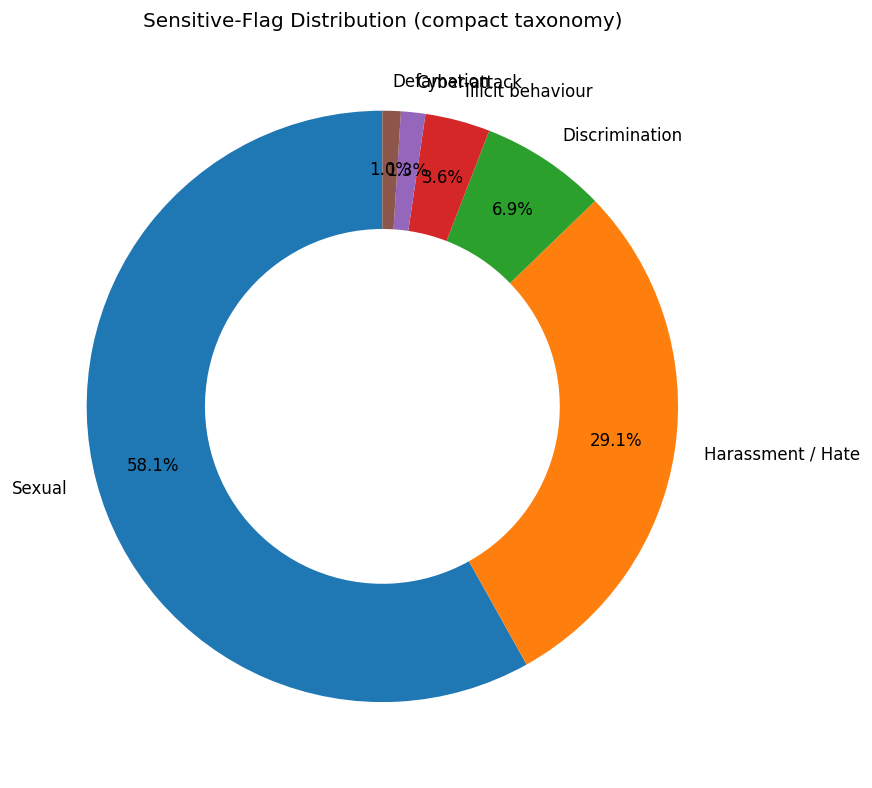

In [39]:
import json, re, itertools, math, functools, random, textwrap, warnings
from collections import defaultdict, Counter
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.rcParams.update({"figure.dpi": 120})
warnings.filterwarnings("ignore")

# Make sure dataset is loaded in `dataset`
# dataset = Dataset.load_yours()  # <-- your existing load call


# 1-A  ===== mapping helper  ================================================
flag_map = {
    # Sexual / erotic
    "Sexually explicit content (Other)": "Sexual",
    "Sexually explicit content (Under 18)": "Sexual",
    "Sexually explicit content": "Sexual",

    # Violence, harassment, hateful behaviour
    "Inciting violence, hateful or other harmful behavior (harassment & bullying)": "Harassment / Hate",
    "Inciting violence, hateful or other harmful behavior (physical harm)": "Harassment / Hate",
    "Inciting violence, hateful or other harmful behavior (self-harm)": "Harassment / Hate",

    # Crime / illegal
    "Criminal planning or other suspected illegal activity not listed": "Illicit behaviour",
    "Criminal planning or other suspected illegal activity not listed elsewhere": "Illicit behaviour",

    # Cyber-attacks
    "Cyberattacks": "Cyber-attack",
    "Cyberattacks (enabling/enacting malware, computer viruses, worms, malicious code, ...)": "Cyber-attack",

    # Defamation / reputation
    "Generating defamatory content": "Defamation",
    "Impersonation attempts": "Defamation",

    # Discrimination
    "Discriminatory practices (Misrepresentation, stereotyping, or inappropriate reference to sensitive attributes)": "Discrimination",
}


def extract_flags(msg, key="automatic_v0-turn_sensitive_use_flags"):
    """
    Return a *list* of raw sensitive-flag strings for this message.
    Works whether `metadata` is a dict or an AnnotationRecord-like object.
    """
    meta = getattr(msg, "metadata", None)
    if meta is None:
        return []

    try:                        # dict-like with `get`
        record = meta.get(key)
    except AttributeError:      # AnnotationRecord – no `.get`
        record = meta[key] if key in meta else None

    if record is None:
        return []

    val = getattr(record, "value", None)
    if val is None:
        return []

    return val if isinstance(val, list) else [val]

def map_flag(raw):
    """Return compact label or None"""
    return flag_map.get(raw)

# 1-B  ===== count flags per turn ===========================================
turn_flag_counts = Counter()
turn_flag_by_country = Counter()
turn_flag_by_country_cat = defaultdict(lambda: Counter())

for conv in dataset.data:
    country = (conv.geography or "Unknown").split(";")[0].strip()
    
    for msg in conv.conversation:
        raw_list = extract_flags(msg)     # <-- instead of the .get(…).get("value") chain
        
        for r in raw_list:
            short = map_flag(r)
    
            if short:                       # skip None / unknown
                turn_flag_counts[short] += 1
                turn_flag_by_country[country] += 1
                turn_flag_by_country_cat[country][short] += 1


print(turn_flag_counts.keys())
labels, values = zip(*turn_flag_counts.most_common())

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autot = ax.pie(values, labels=labels, startangle=90, autopct="%1.1f%%",
                              pctdistance=0.8, textprops={"fontsize": 10})

# donut hole
plt.setp(wedges, width=0.4)
ax.set_title("Sensitive-Flag Distribution (compact taxonomy)")
plt.show()


In [33]:
labels

('Harassment / Hate',
 'Discrimination',
 'Illicit behaviour',
 'Cyber-attack',
 'Defamation')

# RQ 2 2. Pie  Chart of Country Contribution to Sensitive Flags


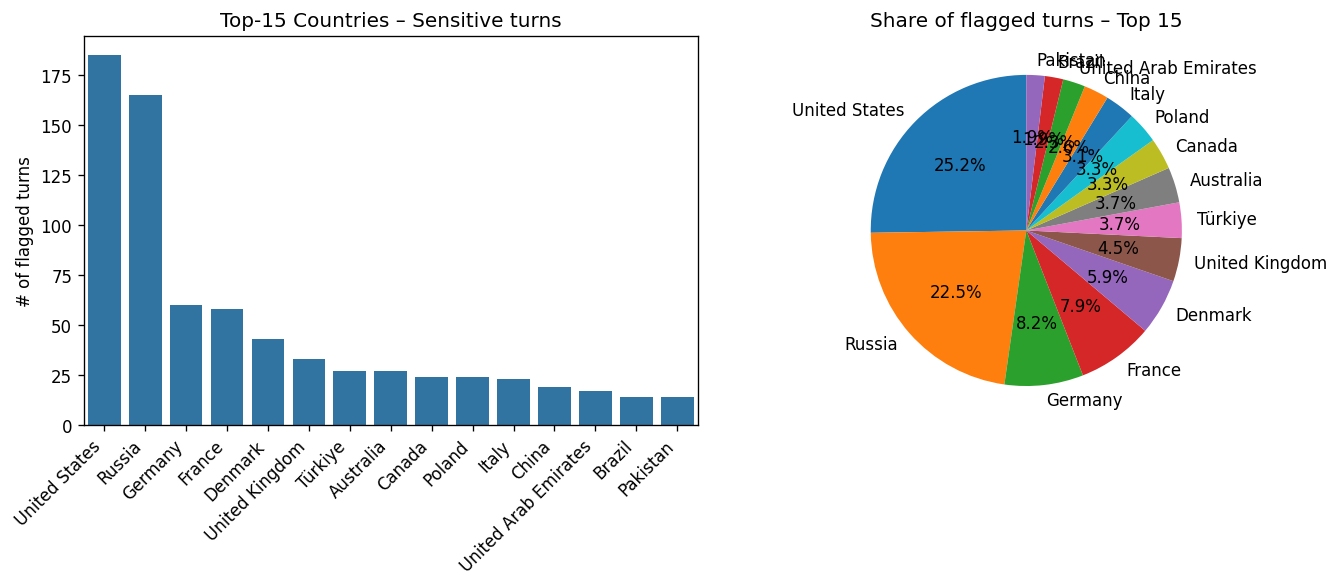

In [41]:
N = 15
countries, counts = zip(*turn_flag_by_country.most_common(N))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=list(countries), y=list(counts))
plt.xticks(rotation=45, ha="right"); plt.xlabel(""); plt.ylabel("# of flagged turns")
plt.title(f"Top-{N} Countries – Sensitive turns")

plt.subplot(1, 2, 2)
plt.pie(counts, labels=countries, autopct="%1.1f%%", startangle=90, radius=1)
plt.title(f"Share of flagged turns – Top {N}")
plt.tight_layout(); plt.show()


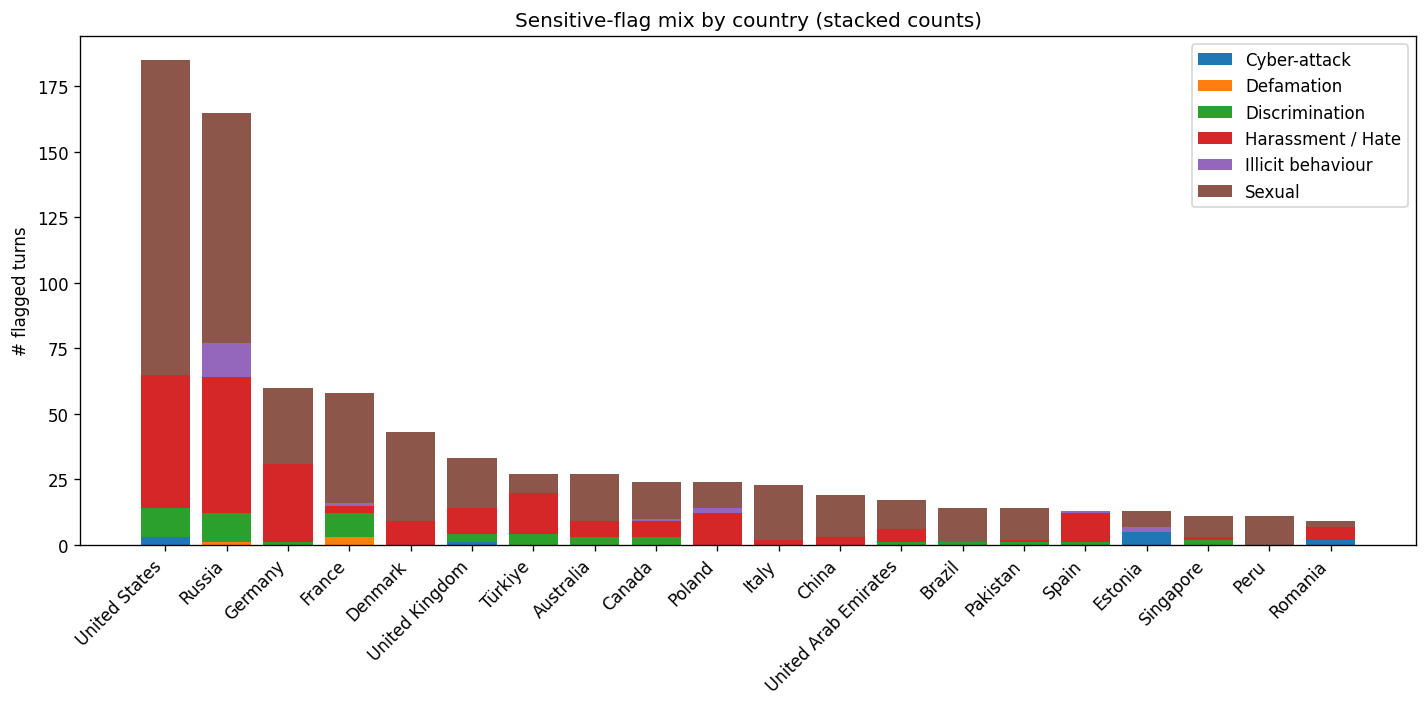

In [68]:
# ------------------------------------------------------------------
#  Stacked bar: sensitive-flag mix by country   (absolute counts)
# ------------------------------------------------------------------
top_countries = [c for c, _ in turn_flag_by_country.most_common(20)]
cats          = sorted(turn_flag_counts.keys())          # stable order

# build per-category series
series = {cat: np.array([turn_flag_by_country_cat[c][cat] for c in top_countries])
          for cat in cats}

plt.figure(figsize=(12,6))
bottom = np.zeros(len(top_countries))

for cat in cats:
    plt.bar(top_countries, series[cat], bottom=bottom, label=cat)
    bottom += series[cat]

plt.ylabel("# flagged turns")
plt.title("Sensitive-flag mix by country (stacked counts)")
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout(); plt.show()


# RQ 3 Normalized Bar Chart by Country's Total Queries

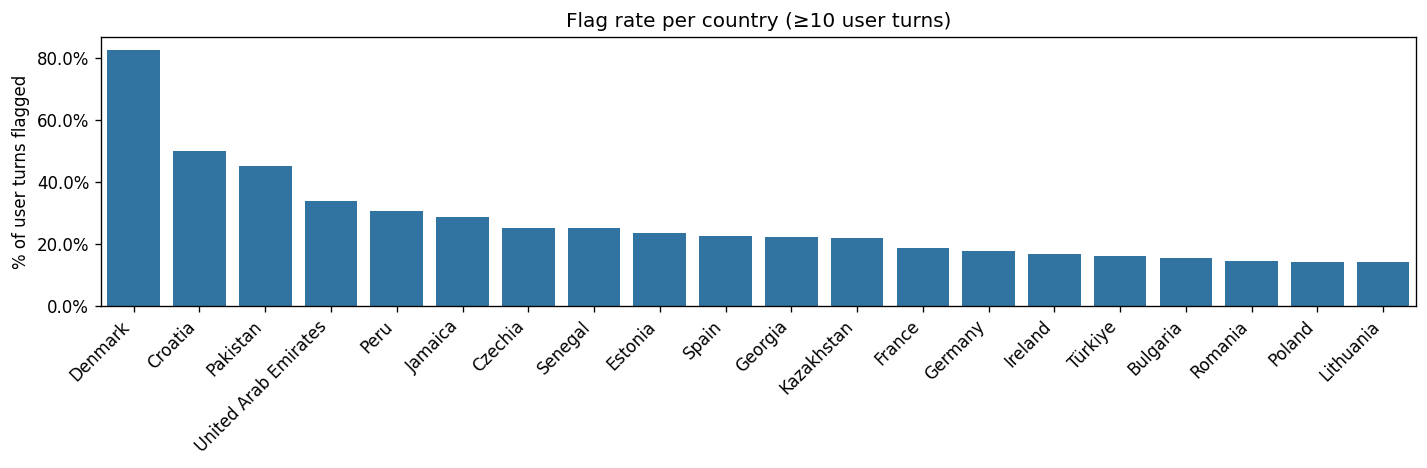

In [ ]:
country_totals = Counter()
for conv in dataset.data:
    country = (conv.geography or "Unknown").split(";")[0].strip()
    country_totals[country] += len([m for m in conv.conversation if m.role=="user"])

rate = {c: (turn_flag_by_country[c] / country_totals[c]) for c in country_totals if country_totals[c] >= 5}
rate_top = dict(sorted(rate.items(), key=lambda x: x[1], reverse=True)[:20])

plt.figure(figsize=(12,4))
sns.barplot(x=list(rate_top.keys()), y=list(rate_top.values()))
plt.gca().yaxis.set_major_formatter(lambda x,pos: f"{x:.1%}")
plt.xticks(rotation=45, ha="right")
plt.ylabel("% of user turns flagged"); plt.title("Flag rate per country (≥5 user turns)"); plt.tight_layout(); plt.show()


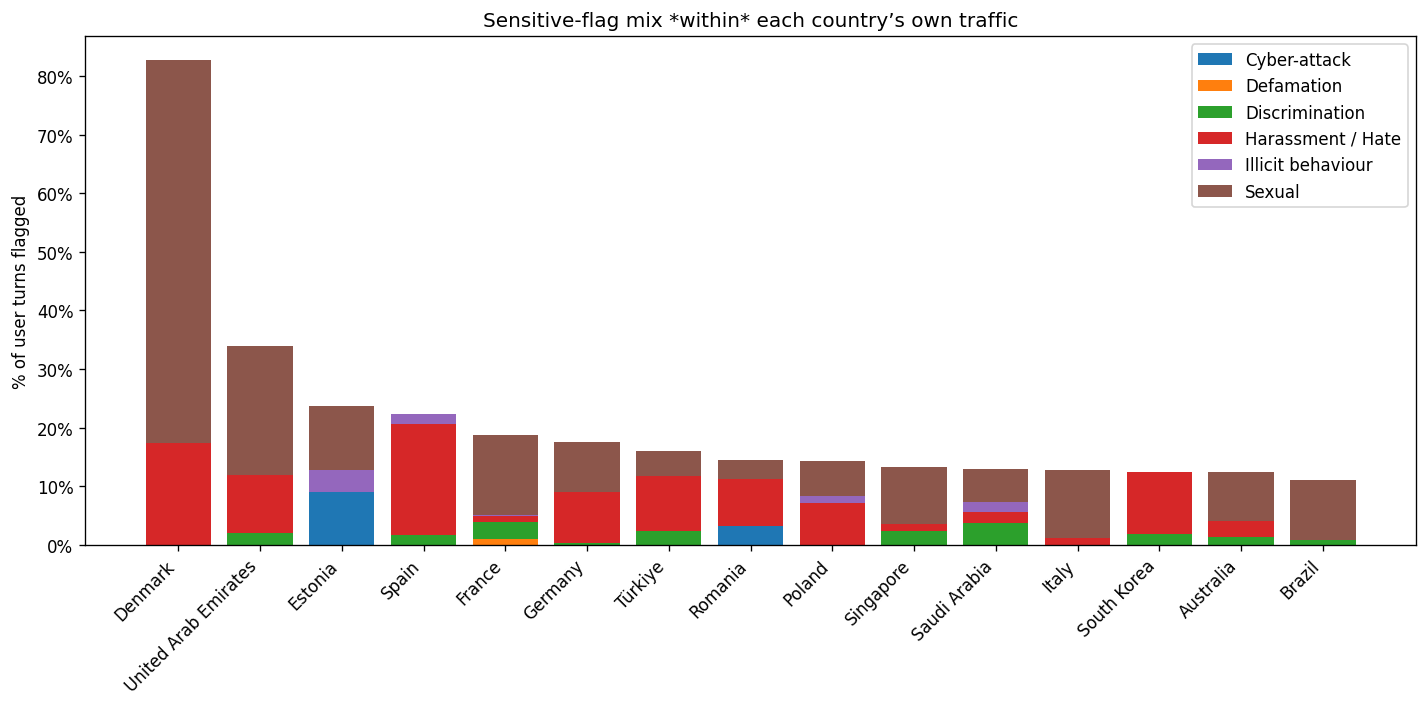

In [63]:
# ――― parameters ―――
TOP = 15           # how many countries to show
MIN_TURNS = 50     # only analyse countries with ≥ this many user turns

# ――― aggregate ―――
country_totals   = Counter()
country_cat_hits = defaultdict(Counter)

for conv in dataset.data:
    country = (conv.geography or "Unknown").split(";")[0].strip()
    for msg in conv.conversation:
        if msg.role != "user": 
            continue
        country_totals[country] += 1
        for r in extract_flags(msg):
            cat = map_flag(r)
            if cat:
                country_cat_hits[country][cat] += 1

# choose countries
eligible = [c for c,t in country_totals.items() if t >= MIN_TURNS]
ranked = sorted(eligible, key=lambda c: sum(country_cat_hits[c].values())/country_totals[c], reverse=True)[:TOP]

cats = sorted({cat for counts in country_cat_hits.values() for cat in counts})
stack = {cat: [country_cat_hits[c][cat]/country_totals[c] for c in ranked] for cat in cats}

# ――― plot ―――
bottom = np.zeros(len(ranked))
plt.figure(figsize=(12,6))
for cat in cats:
    plt.bar(ranked, stack[cat], bottom=bottom, label=cat)
    bottom += stack[cat]

plt.gca().yaxis.set_major_formatter(lambda x,pos: f"{x:.0%}")
plt.xticks(rotation=45, ha="right")
plt.ylabel("% of user turns flagged")
plt.title("Sensitive-flag mix *within* each country’s own traffic")
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout(); plt.show()


# RQ 4 4. Temporal Analysis of Sensitive Flags


[datetime.datetime(2023, 4, 25, 2, 20, 46, tzinfo=datetime.timezone.utc), datetime.datetime(2023, 4, 12, 3, 15, 53, tzinfo=datetime.timezone.utc), datetime.datetime(2023, 4, 9, 17, 16, 40, tzinfo=datetime.timezone.utc), datetime.datetime(2023, 4, 26, 23, 43, 52, tzinfo=datetime.timezone.utc), datetime.datetime(2023, 4, 16, 22, 25, 35, tzinfo=datetime.timezone.utc)]


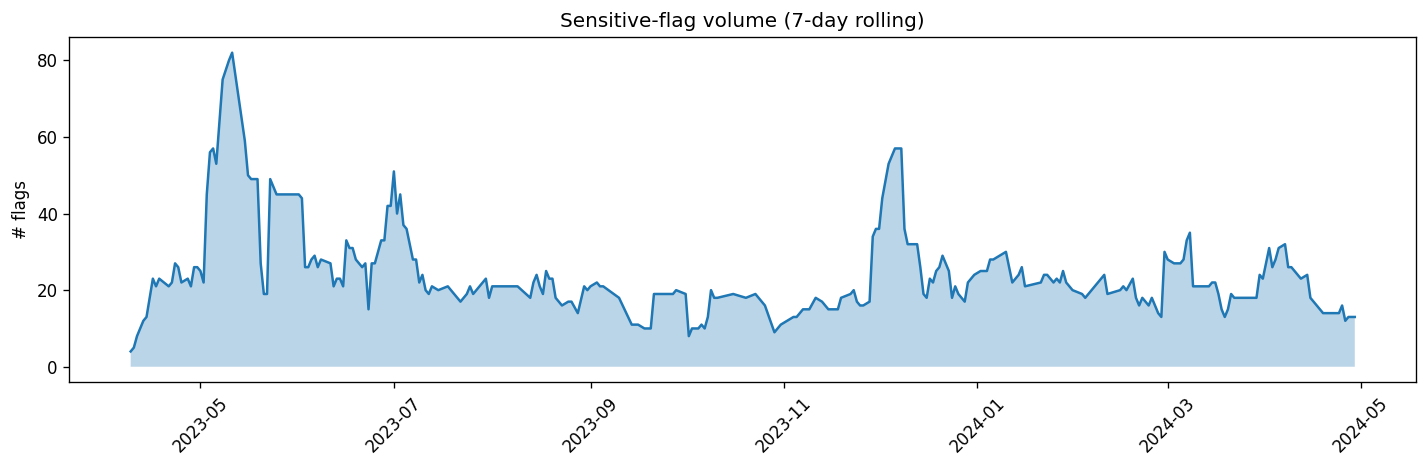

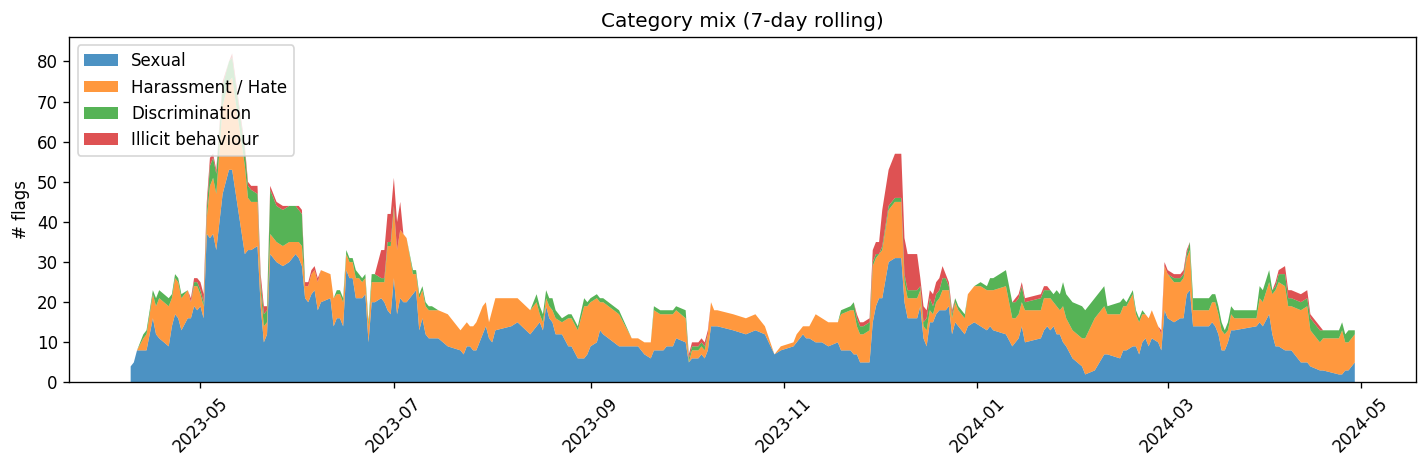

In [52]:
def get_datetime(msg, conv):
    """
    Return a `datetime` for the message if available,
    otherwise fall back to the conversation’s timestamp.
    Returns None if nothing is present.
    """
    # Common field names we’ve seen in the various classes
    for attr in ("time", "timestamp", "created_at", "date"):
        val = getattr(msg, attr, None)
        if val: break
    else:                                # loop didn't break → try the conv
        for attr in ("time", "timestamp", "created_at", "date"):
            val = getattr(conv, attr, None)
            if val: break
        else:
            return None                  # give up

    # Convert ISO-8601 / RFC3339 strings to python datetime
    if isinstance(val, str):
        return datetime.fromisoformat(val.replace("Z", "+00:00"))
    if isinstance(val, datetime):
        return val
    # Add other conversion rules if your data stores epochs, etc.
    return None

# create daily series
daily = defaultdict(Counter)
for conv in dataset.data:
    for msg in conv.conversation:
        dt = get_datetime(msg, conv)
        if dt is None:
            continue                     # skip if we still couldn't parse a date
        t = dt.date()

        for r in extract_flags(msg):     # ← uses the earlier helper
            cat = map_flag(r)
            if cat:
                daily[t][cat]  += 1
                daily[t]["total"] += 1
sample_dt = [get_datetime(conv.conversation[0], conv) for conv in dataset.data[:5]]
print(sample_dt)
# DataFrame & rolling
df = (pd.DataFrame(daily).T
        .sort_index()
        .fillna(0)
        .rolling(window=7, min_periods=1).sum())  # 7-day smooth

# total trend
plt.figure(figsize=(12,4))
plt.plot(df.index, df["total"]); plt.fill_between(df.index, df["total"], alpha=.3)
plt.title("Sensitive-flag volume (7-day rolling)"); plt.ylabel("# flags"); plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m")); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# stacked area of top 4 cat
top4 = df.drop(columns="total").sum().nlargest(4).index
plt.figure(figsize=(12,4))
plt.stackplot(df.index, *[df[c] for c in top4], labels=top4, alpha=.8)
plt.legend(loc="upper left"); plt.title("Category mix (7-day rolling)"); plt.ylabel("# flags")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m")); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


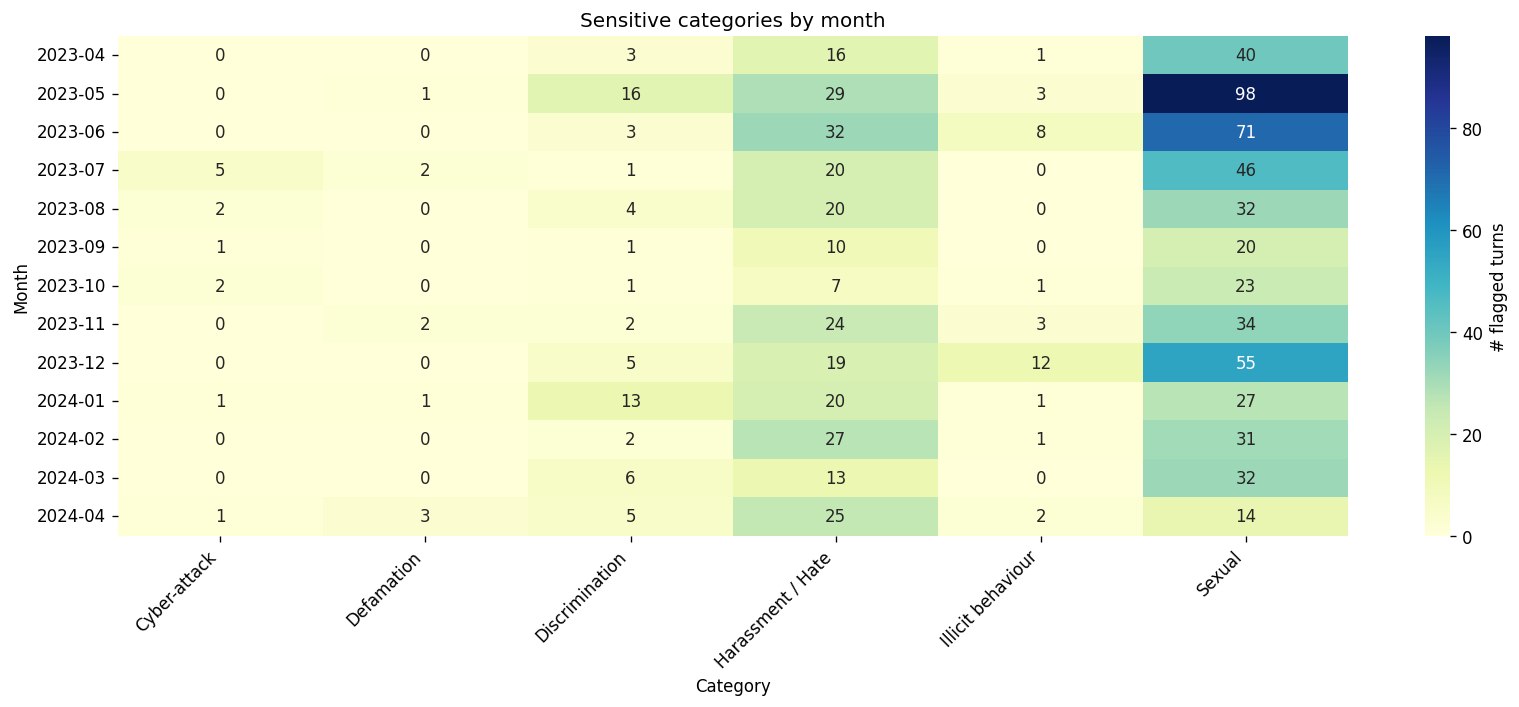

In [64]:
# Build month×category matrix
counts = defaultdict(lambda: Counter())     # month → Counter(cat → hits)

for conv in dataset.data:
    for msg in conv.conversation:
        dt = get_datetime(msg, conv)
        if dt is None: continue
        month = dt.strftime("%Y-%m")
        for r in extract_flags(msg):
            cat = map_flag(r)
            if cat:
                counts[month][cat] += 1

months = sorted(counts.keys())
cats   = sorted({cat for m in counts for cat in counts[m]})
mat = np.array([[counts[m][cat] for cat in cats] for m in months])

plt.figure(figsize=(14,6))
sns.heatmap(mat, xticklabels=cats, yticklabels=months, cmap="YlGnBu", annot=True, fmt="d",
            cbar_kws={"label":"# flagged turns"})
plt.title("Sensitive categories by month")
plt.xlabel("Category"); plt.ylabel("Month")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


# 6. Sensitive Flags Progression Through Turns


Total conversations with any sensitivity: 459
   ├─ Start sensitive (turn-0):  351
   └─ Become sensitive later :  108


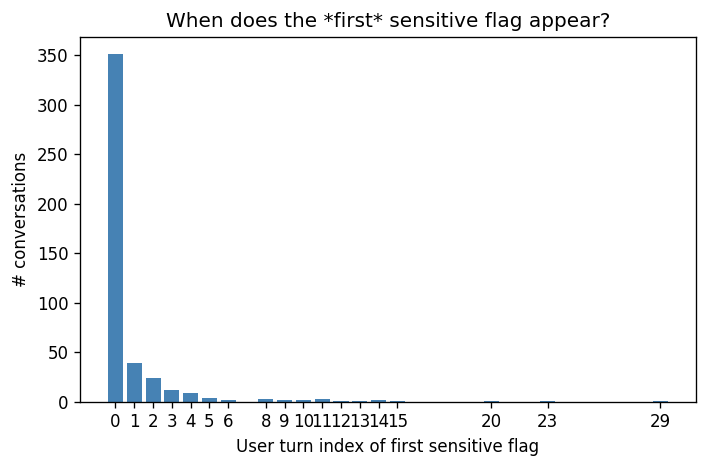

In [73]:
first_flag_turn = Counter()     # 0 = first user turn, 1 = second, …
started_sensitive = 0
became_sensitive  = 0

for conv in dataset.data:
    user_msgs = [m for m in conv.conversation if m.role == "user"]
    flag_turn = None

    for i, msg in enumerate(user_msgs):
        if any(map_flag(r) for r in extract_flags(msg)):
            flag_turn = i
            break

    if flag_turn is None:
        continue                        # conversation never sensitive

    first_flag_turn[flag_turn] += 1

    if flag_turn == 0:                  # ← FIXED
        started_sensitive += 1
    else:
        became_sensitive += 1


print(f"Total conversations with any sensitivity: {sum(first_flag_turn.values())}")
print(f"   ├─ Start sensitive (turn-0):  {started_sensitive}")
print(f"   └─ Become sensitive later :  {became_sensitive}")

plt.figure(figsize=(6,4))
turns, counts = zip(*sorted(first_flag_turn.items()))
plt.bar(turns, counts, color="steelblue")
plt.xlabel("User turn index of first sensitive flag")
plt.ylabel("# conversations")
plt.title("When does the *first* sensitive flag appear?")
plt.xticks(turns); plt.tight_layout(); plt.show()


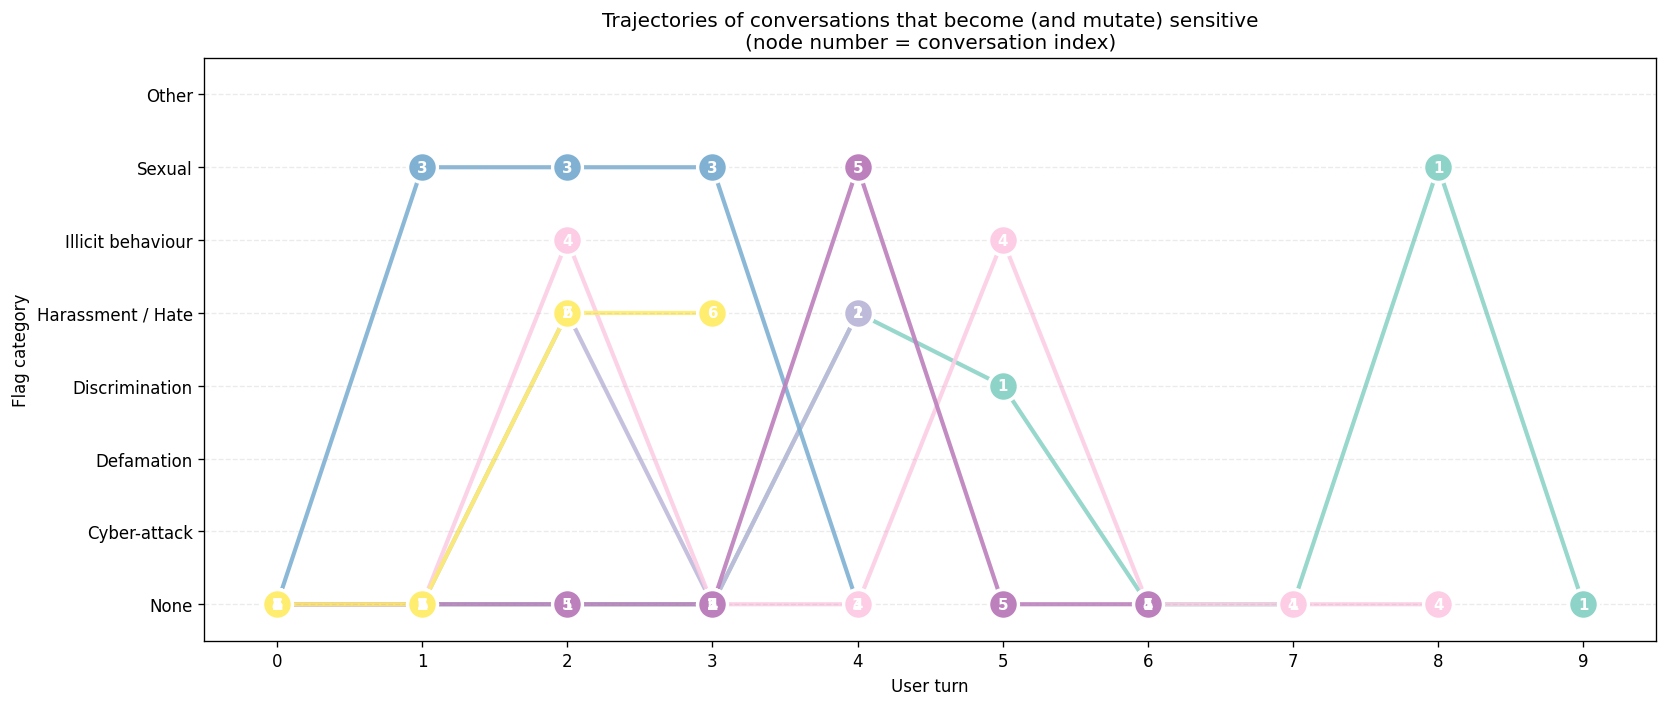

In [83]:
# ------------------------------------------------------------------
#  “Rail” diagram – each conversation a distinct colour, no numbers
#  + print 2 example convo IDs with their category progression
# ------------------------------------------------------------------
# ---------------------------------------------------------------
#  Rail diagram – colour + conversation number in every node
# ---------------------------------------------------------------
import numpy as np, matplotlib.pyplot as plt, random

MAX_TURNS = 10
SAMPLES   = 6                 # keep viewable
seed = 10

random.seed(seed)
sampled = random.sample(later_convs, min(SAMPLES, len(later_convs)))

palette = plt.cm.Set3(np.linspace(0, 1, len(sampled)))

fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlim(-0.5, MAX_TURNS-0.5)
ax.set_ylim(-0.5, len(levels)-0.5)

ax.set_xticks(range(MAX_TURNS))
ax.set_yticks(range(len(levels)))
ax.set_yticklabels(["None"] + CATEGORIES + ["Other"])
ax.grid(axis="y", linestyle="--", alpha=.25)
ax.set_xlabel("User turn")
ax.set_ylabel("Flag category")

for idx, (path, clr) in enumerate(zip(sampled, palette), start=1):
    y = [levels[c] if c else levels[None] for c in path]
    x = list(range(len(path)))

    ax.plot(x, y, color=clr, linewidth=2.5, alpha=.9, zorder=1)
    ax.scatter(x, y, s=320, color=clr, edgecolor="white", linewidth=2, zorder=2)

    # put conversation index inside every node
    for xi, yi in zip(x, y):
        ax.text(xi, yi, str(idx), ha="center", va="center",
                color="white", fontsize=9, weight="bold", zorder=3)

ax.set_title("Trajectories of conversations that become (and mutate) sensitive\n"
             "(node number = conversation index)")
plt.tight_layout(); plt.show()




In [84]:
# ------------------------------------------------------------------
#  Print TWO full conversations that start clean → become sensitive
#  and switch category at least once
# ------------------------------------------------------------------
MAX_TURNS_ANALYSED = 10          # used earlier for later_convs logic

good_convos = []
for conv in dataset.data:
    user_msgs = [m for m in conv.conversation if m.role == "user"][:MAX_TURNS_ANALYSED]
    cats = [next((map_flag(r) for r in extract_flags(m) if map_flag(r)), None)
            for m in user_msgs]

    if cats and cats[0] is None and any(cats[1:]):          # starts clean, later flagged
        non_none = [c for c in cats if c]
        if len(set(non_none)) >= 2:                         #   … and category changes
            good_convos.append(conv)
    if len(good_convos) == 2:
        break

print("\n=== Two conversations that evolve from clean → sensitive and mutate ===\n")
for conv in good_convos:
    print(f"Conversation ID: {conv.conversation_id}\n" + "-"*80)
    for idx, msg in enumerate(conv.conversation):
        cat_labels = [map_flag(r) for r in extract_flags(msg) if map_flag(r)]
        cat_str = ", ".join(cat_labels) if cat_labels else "None"
        role = msg.role.ljust(9)              # pad for alignment
        print(f"[{idx:02d}] {role} | {cat_str}")
        print(textwrap.indent(msg.content.strip(), prefix="       "))
        print()
    print("="*80 + "\n")



=== Two conversations that evolve from clean → sensitive and mutate ===

Conversation ID: wildchat_704169bb58f3ac6e1d8e5f3216499ae5
--------------------------------------------------------------------------------
[00] user      | None
       ответь на письмо от имени девушки Dearest Inna,

       I would gladly make many compromises to make serious relationship work for us to be together as married couple living together. I am putting love first for everything in life or things will never workout for any future serious relationship together.

       But marriage is equal partnership where we share everything together and we help each other get through both good and bad times together as married couple.

       Age is just a number to me personally. You are as young as you feel from within yourself.

       So, age differences it not much of a real difference, when all we want from life is to be happy together.

       I will love you no matter what your age was to me, as your husband,

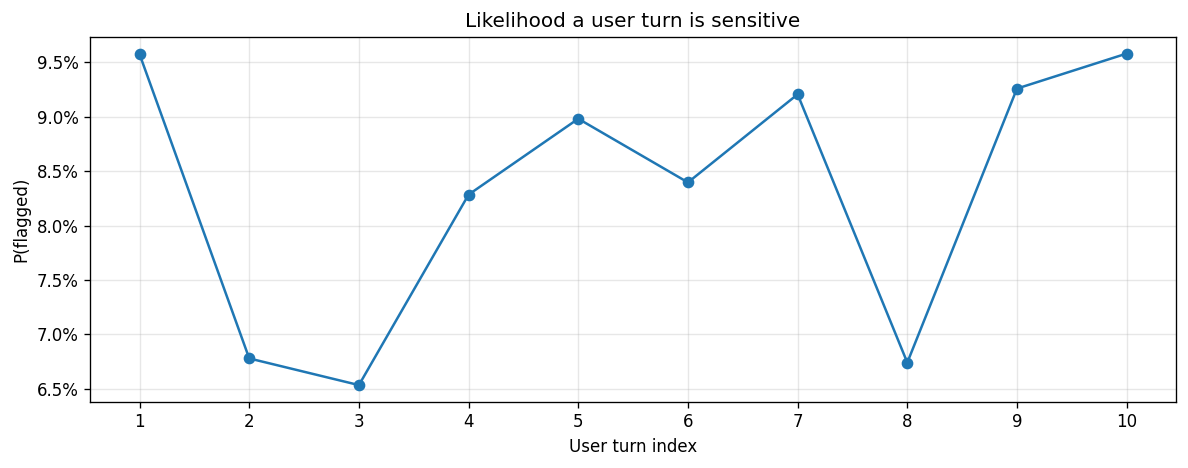

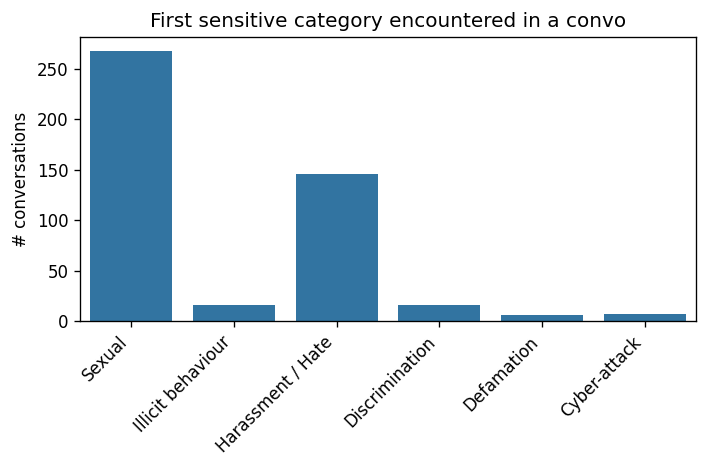

In [54]:
MAX_TURNS = 10
turn_series = [Counter() for _ in range(MAX_TURNS)]
n_convs_with_turn = Counter()

for conv in dataset.data:
    user_msgs = [m for m in conv.conversation if m.role == "user"]

    for i, msg in enumerate(user_msgs[:MAX_TURNS]):
        n_convs_with_turn[i] += 1

        for r in extract_flags(msg):          # ← SAFE ACCESS
            cat = map_flag(r)
            if cat:
                turn_series[i][cat] += 1


# A) probability of *any* sensitive flag by turn#
prob_any = [ sum(turn_series[i].values())/n_convs_with_turn[i] if n_convs_with_turn[i] else 0
             for i in range(MAX_TURNS) ]

plt.figure(figsize=(10,4))
plt.plot(range(1,MAX_TURNS+1), prob_any, marker="o")
plt.gca().yaxis.set_major_formatter(lambda x,pos: f"{x:.1%}")
plt.xticks(range(1,MAX_TURNS+1)); plt.xlabel("User turn index"); plt.ylabel("P(flagged)")
plt.title("Likelihood a user turn is sensitive"); plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

# B) which category pops up first?
first_flag = Counter()
for conv in dataset.data:
    user_msgs = [m for m in conv.conversation if m.role=="user"]
    for i, msg in enumerate(user_msgs):
        raw = extract_flags(msg)
        raw = raw if isinstance(raw, list) else [raw]
        cats = [map_flag(r) for r in raw if map_flag(r)]
        if cats:
            first_flag[cats[0]] += 1
            break

plt.figure(figsize=(6,4))
sns.barplot(x=list(first_flag.keys()), y=list(first_flag.values()))
plt.xticks(rotation=45, ha="right"); plt.ylabel("# conversations")
plt.title("First sensitive category encountered in a convo"); plt.tight_layout(); plt.show()


Analysis 1: Co-occurrence of Sensitive Flag Types


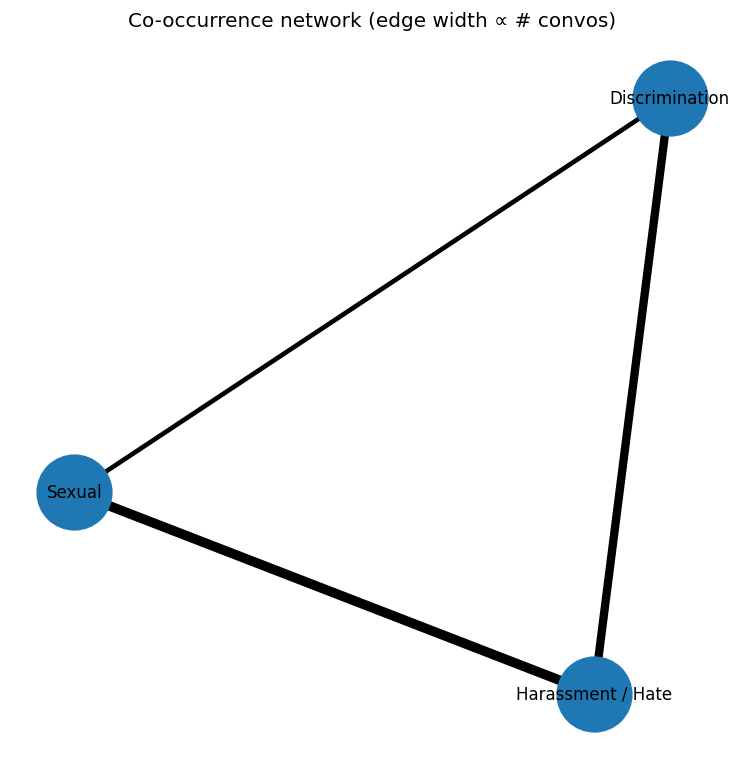

In [56]:
import networkx as nx

pair_counter = Counter()
flag_counter = Counter()

for conv in dataset.data:
    convo_flags = set()
    for msg in conv.conversation:
        raw = extract_flags(msg)
        raw = raw if isinstance(raw, list) else [raw]
        convo_flags.update(map_flag(r) for r in raw if map_flag(r))
    convo_flags.discard(None)
    for f in convo_flags: flag_counter[f] += 1
    for a,b in itertools.combinations(sorted(convo_flags),2):
        pair_counter[(a,b)] += 1

# keep pairs that co-occur ≥10
G = nx.Graph()
for (a,b), n in pair_counter.items():
    if n >= 10:
        lift = n / (flag_counter[a]*flag_counter[b]/len(dataset.data))
        G.add_edge(a,b,weight=n,lift=lift)

plt.figure(figsize=(6,6))
pos = nx.spring_layout(G, seed=0)
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw(G,pos,with_labels=True,width=[w/5 for w in weights],node_size=2000,
        font_size=10)
plt.title("Co-occurrence network (edge width ∝ # convos)")
plt.show()


Analysis 2: Conversation Length vs Sensitive Content


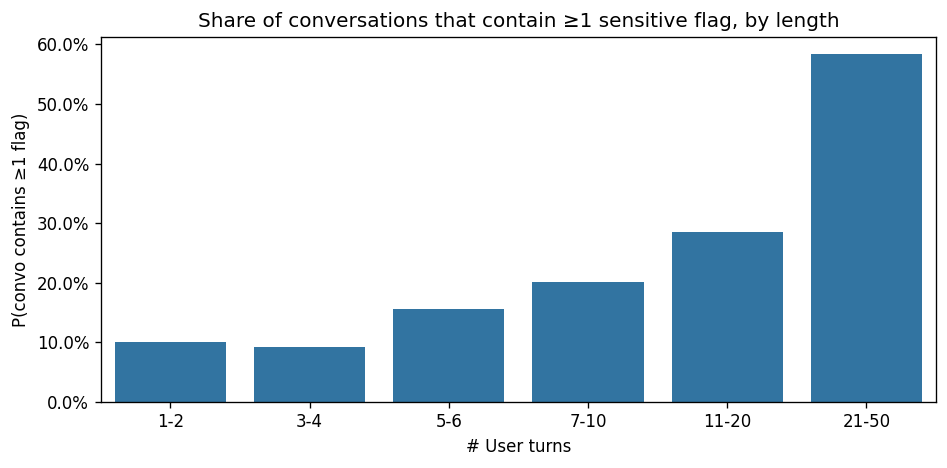

In [67]:
lengths = []
for conv in dataset.data:
    user_turns = [m for m in conv.conversation if m.role=="user"]
    has_flag = any(map_flag(r)
                   for msg in user_turns
                   for r in (extract_flags(msg) 
                             if isinstance(extract_flags(msg), list)
                             else [extract_flags(msg)]))
    lengths.append((len(user_turns), has_flag))

df_len = pd.DataFrame(lengths, columns=["n_turns","flag"])
df_len["n_turns_bin"] = pd.cut(df_len["n_turns"], bins=[0,2,4,6,10,20,50], labels=["1-2","3-4","5-6","7-10","11-20","21-50"])

rate_by_bin = df_len.groupby("n_turns_bin")["flag"].mean().reset_index()

plt.figure(figsize=(8,4))
sns.barplot(x="n_turns_bin", y="flag", data=rate_by_bin)
plt.gca().yaxis.set_major_formatter(lambda x,pos: f"{x:.1%}")
plt.xlabel("# User turns"); plt.ylabel("P(convo contains ≥1 flag)")
plt.title("Share of conversations that contain ≥1 sensitive flag, by length")
plt.tight_layout(); plt.show()
